In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder

# 1. Data

In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
test_df = pd.read_csv('test.csv')

In [4]:
train_df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# 2. Feature Engineering

In [6]:
full_data = [train_df, test_df]

### A. Cabin

In [7]:
train_df['Cabin'] = train_df['Cabin'].notnull().astype(int)
test_df['Cabin'] = test_df['Cabin'].notnull().astype(int)

### B. Family Size 

In [8]:
for data in full_data:
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

### C. IsAlone

In [9]:
for data in full_data:
    family_size = data['FamilySize']
    isalone = []
    
    for i in family_size:
        if i==1:
            isalone.append(1)
        elif i>1:
            isalone.append(0)
    
    data['IsAlone'] = isalone

In [10]:
train_df.head(2)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   

   Parch     Ticket     Fare  Cabin Embarked  FamilySize  IsAlone  
0      0  A/5 21171   7.2500      0        S           2        0  
1      0   PC 17599  71.2833      1        C           2        0

#### D. Gender

In [11]:
# Used LabelEncoder to transform male and female to 1 and 0

In [12]:
Encoder = LabelEncoder()

for data in full_data:
    Encoder.fit(data['Sex'])
    data['Sex'] = Encoder.transform(data['Sex'])

#### E. Age 

In [13]:
# Fill the null values with medium

In [14]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

In [15]:
# Split into groups 

In [16]:
for data in full_data:
    data['Age Group'] = pd.cut(data['Age'], 5, labels = [0, 1, 2, 3, 4])
    data['Age Group'] = data['Age Group'].astype(int)

#### F. Name

In [17]:
def get_title(name):
    
    # Looking for a title infront of the name
    title_search = re.search('([A-Za-z]+)\.', name)
    
    if title_search:
        return title_search.group(1)
    return ""

In [18]:
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [19]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [20]:
for data in full_data:
    data['Title'].replace(['Mr', 'Miss', 'Mrs'], '1',inplace = True)
    data['Title'].replace(['Master', 'Rare'], ['2','3'], inplace = True)

#### G. Embarked

In [21]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode()[0])
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

#### H. Fare

In [22]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].mode()[0])
    
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

### Drop Features

In [23]:
train_df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex  Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    1   22      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0   38      1      0   
2                             Heikkinen, Miss. Laina    0   26      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0   35      1      0   
4                           Allen, Mr. William Henry    1   35      0      0   

             Ticket  Fare  Cabin  Embarked  FamilySize  IsAlone  Age Group  \
0         A/5 21171     0      0         0           2        0          1   
1          PC 17599     3      1         1           2        0          2   
2  STON/O2. 3101282     1      0         0           1        1          1   
3            113803     3      1         0           2        0          2   
4            373450     1      0         0           1        1          2   

  Title  
0     1  
1     1  
2     1  
3     1  
4     1

In [24]:
train_df = train_df.drop(columns = ['Name', 'Ticket'])
test_df = test_df.drop(columns = ['Name', 'Ticket'])

In [25]:
test_df.head()

PassengerId  Pclass  Sex  Age  SibSp  Parch  Fare  Cabin  Embarked  \
0          892       3    1   34      0      0     0      0         2   
1          893       3    0   47      1      0     0      0         0   
2          894       2    1   62      0      0     1      0         2   
3          895       3    1   27      0      0     1      0         0   
4          896       3    0   22      1      1     1      0         0   

   FamilySize  IsAlone  Age Group Title  
0           1        1          2     1  
1           2        0          3     1  
2           1        1          4     1  
3           1        1          1     1  
4           3        0          1     1

# 3. Description of Features



Survived (0,1) = Died, Lived

Pclass   (1,2,3) = High, Mid, Low

Sex (0,1) = Female , Male

SibSp = Number of Siblings on Board

Parch = Number of Parents on Board

Fare (0,1,2,3) = Low ---> High

Cabin (0,1) = No Cabin, Cabin

Embarked = (0,1,2) = S,C,Q

FamilySize = Number of Family members on board

IsAlone (1,0) = True, False

AgeGroup(0,1,2,3,4) = Young ----> Old

Title(1,2,3) = 1: [Mr, Miss, Mrs.] 2: Master 3: Rare

# 4. Heat Map

In [26]:
train_df.corr().sort_values(by = ('Survived'), ascending = False)['Survived']

Survived       1.000000
Cabin          0.316912
Fare           0.295875
Embarked       0.106811
Parch          0.081629
FamilySize     0.016639
PassengerId   -0.005007
SibSp         -0.035322
Age Group     -0.056418
Age           -0.069244
IsAlone       -0.203367
Pclass        -0.338481
Sex           -0.543351
Name: Survived, dtype: float64

In [27]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Correlation Matrix', y=1.05, size=15)

sns.heatmap(train_df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

# 5. Histogram

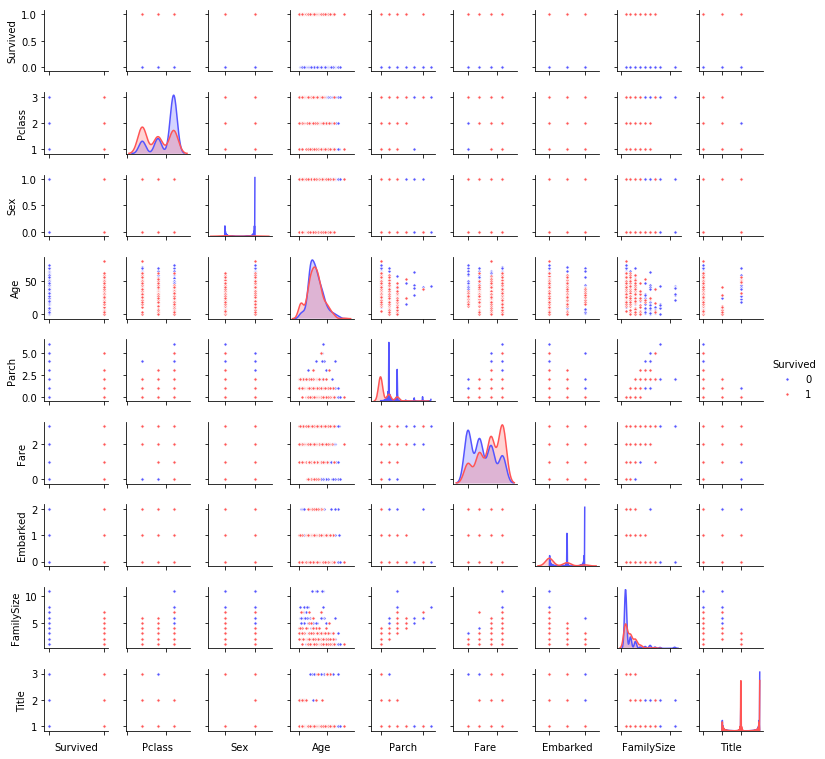

In [28]:
g = sns.pairplot(train_df[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

# 6. Ensembling & Stacking Models

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier

from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

##### Models to solve the problem

In [30]:
X_train = train_df.drop(['Survived', 'PassengerId'], axis = 1)
Y_train = train_df['Survived']
X_test = test_df.drop('PassengerId', axis = 1)
X_train.shape, Y_train.shape, X_test.shape

((891, 12), (891,), (418, 12))

In [31]:
X_train.head(1)

Pclass  Sex  Age  SibSp  Parch  Fare  Cabin  Embarked  FamilySize  IsAlone  \
0       3    1   22      1      0     0      0         0           2        0   

   Age Group Title  
0          1     1

In [32]:
X_test.head(1)

Pclass  Sex  Age  SibSp  Parch  Fare  Cabin  Embarked  FamilySize  IsAlone  \
0       3    1   34      0      0     0      0         2           1        1   

   Age Group Title  
0          2     1

In [33]:
Y_train.head(1)

0    0
Name: Survived, dtype: int64

#### A. Logistic Regression 

In [34]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) *100, 2)

In [35]:
acc_log

80.81

In [36]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

Feature  Correlation
11   Age Group     0.804850
6         Fare     0.802412
5        Parch     0.333663
8     Embarked     0.275972
7        Cabin     0.216979
2          Sex    -0.023448
10     IsAlone    -0.159589
9   FamilySize    -0.415312
0     Survived    -0.440882
4        SibSp    -0.565321
3          Age    -0.840773
1       Pclass    -2.645741
12       Title          NaN

### B. Support Vector Machines

In [37]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)

In [38]:
acc_svc

86.31

### C. Linear SVC

In [39]:
linearsvc = LinearSVC()
linearsvc.fit(X_train, Y_train)
Y_pred = linearsvc.predict(X_test)
acc_linearsvc = round(linearsvc.score(X_train, Y_train) * 100, 2)

In [40]:
acc_linearsvc

80.92

### D. KNearest Neighbor

In [41]:
knn = KNeighborsClassifier(n_neighbors= 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train,Y_train) * 100,2)

In [42]:
acc_knn

88.1

### E. Gaussian Naive Bayes

In [43]:
gnb = GaussianNB()
gnb.fit(X_train, Y_train)
Y_pred = gnb.predict(X_test)
acc_gnb = round(gnb.score(X_train, Y_train) * 100, 2)

In [44]:
acc_gnb

78.34

### E. Perceptron

In [45]:
per = Perceptron()
per.fit(X_train, Y_train)
Y_pred = per.predict(X_test)
acc_perceptron = round(per.score(X_train, Y_train) * 100, 2)
acc_perceptron


74.07

### F. Stochastic Gradient Desent

In [48]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

71.83

### G. Decision Tree

In [50]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100,2)

In [51]:
acc_decision_tree

96.41

### H. Random Forest

In [57]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

96.41

In [60]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gnb, acc_perceptron, 
              acc_sgd, acc_linearsvc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

Model  Score
3               Random Forest  96.41
8               Decision Tree  96.41
1                         KNN  88.10
0     Support Vector Machines  86.31
7                  Linear SVC  80.92
2         Logistic Regression  80.81
4                 Naive Bayes  78.34
5                  Perceptron  74.07
6  Stochastic Gradient Decent  71.83

## 7. Submission

In [62]:
# Using Random Forest

In [63]:
test_df

PassengerId  Pclass  Sex  Age  SibSp  Parch  Fare  Cabin  Embarked  \
0            892       3    1   34      0      0     0      0         2   
1            893       3    0   47      1      0     0      0         0   
2            894       2    1   62      0      0     1      0         2   
3            895       3    1   27      0      0     1      0         0   
4            896       3    0   22      1      1     1      0         0   
5            897       3    1   14      0      0     1      0         0   
6            898       3    0   30      0      0     0      0         2   
7            899       2    1   26      1      1     2      0         0   
8            900       3    0   18      0      0     0      0         1   
9            901       3    1   21      2      0     2      0         0   
10           902       3    1   35      0      0     0      0         0   
11           903       1    1   46      0      0     2      0         0   
12           904       1    0   23      1      0     3      1         0   
13           905       2    1   63      1      0     2      0         0   
14           906       1    0   47      1      0     3      1         0   
15           907       2    0   24      1      0     2      0         1   
16           908       2    1   35      0      0     1      0         2   
17           909       3    1   21      0      0     0      0         1   
18           910       3    0   27      1      0     1      0         0   
19           911       3    0   45      0      0     0      0         1   
20           912       1    1   55      1      0     3      0         1   
21           913       3    1    9      0      1     0      0         0   
22           914       1    0   40      0      0     3      0         0   
23           915       1    1   21      0      1     3      0         1   
24           916       1    0   48      1      3     3      1         1   
25           917       3    1   50      1      0     2      0         0   
26           918       1    0   22      0      1     3      1         1   
27           919       3    1   22      0      0     0      0         1   
28           920       1    1   41      0      0     2      1         0   
29           921       3    1   21      2      0     2      0         1   
..           ...     ...  ...  ...    ...    ...   ...    ...       ...   
388         1280       3    1   21      0      0     0      0         2   
389         1281       3    1    6      3      1     2      0         0   
390         1282       1    1   23      0      0     3      1         0   
391         1283       1    0   51      0      1     3      1         0   
392         1284       3    1   13      0      2     2      0         0   
393         1285       2    1   47      0      0     1      0         0   
394         1286       3    1   29      3      1     2      0         0   
395         1287       1    0   18      1      0     3      1         0   
396         1288       3    1   24      0      0     0      0         2   
397         1289       1    0   48      1      1     3      1         1   
398         1290       3    1   22      0      0     0      0         0   
399         1291       3    1   31      0      0     0      0         2   
400         1292       1    0   30      0      0     3      1         0   
401         1293       2    1   38      1      0     2      0         0   
402         1294       1    0   22      0      1     3      0         1   
403         1295       1    1   17      0      0     3      0         0   
404         1296       1    1   43      1      0     2      1         1   
405         1297       2    1   20      0      0     1      1         1   
406         1298       2    1   23      1      0     1      0         0   
407         1299       1    1   50      1      1     3      1         1   
408         1300       3    0   22      0      0     0      0         2   
409         1301       3    0 

In [64]:
submission = pd.DataFrame({
    "PassengerId" : test_df['PassengerId'],
    'Survived' : Y_pred
})

In [65]:
#submission.to_csv("Solution.csv", index=False)